# Chapter 2: Taking Earth's Temperature

### PART III: Visualising Recent Temperature Anomalies <a class="anchor" id="chapter-one"></a>

Imagine you're a seasoned mariner, navigating the vast oceans with nothing but a worn-out map and a compass. You can sense the subtle changes in temperature and weather patterns as you drift from one sea to another. In this journey of "Taking Earth's Temperature," we will be your modern navigational tools, guiding you through the uncharted waters of global temperature anomalies.

This tutorial is Part III of the trilogy “Taking Earth’s Temperature”:

1. **Long-Term Development** of Global Earth Temperature Since 1850
2. **Comparing Re-analysis with Observations since 1950**  
3. **Visualising Recent Temperature Anomalies** ([this notebook](#part-two))


<div class="alert alert-block alert-success">
<b>Objective</b> <br>
    The final part of this trilogy will focus on visualizing recent temperature anomalies across various regions of the Earth. By the end of this chapter, not only will you be able to reproduce Climate Bulletin graphs, but you'll also create them for your chosen regions, just as a mariner charts new territories.
 </a>
</div>


**Here's what we will explore**:

- **Calculating spatial averages**: Understanding how to average temperature data across different regions.
- **Visualizing spatial data with various map projections**: Learning to represent global temperatures using different visual perspectives.

To do this, we will use the temperature data from the ERA5 re-analysis:

| Dataset | Spatial Coverage | Spatial Resolution | Temporal Coverage | Temporal resolution |Provider |
|---------|:-------------:|:------:|:------:|:------:|:------:|
|  [ERA5](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview) |  Global | 0.25º x 0.25º | 1940 - today | Monthly | C3S/ECMWF |

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <th><a href="https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training-cams/master?labpath=vis-animations.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th>
    <th><a href="https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/copernicus-training-cams/blob/master/vis-animations.ipynb">
        <img src = "https://kaggle.com/static/images/open-in-kaggle.svg" alt = "Kaggle"></th>
    <th><a href="https://colab.research.google.com/github/ecmwf-projects/copernicus-training-cams/blob/master/vis-animations.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table>

-----------

#### Getting Set Up

##### Importing the Necessary Packages

We'll start by importing all the required packages.

In [1]:
# Python Standard Libraries
import os
import datetime as dt
import calendar
from string import ascii_lowercase as ABC

# Data Manipulation Libraries
import numpy as np
import pandas as pd
import xarray as xr
import dask

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
import cartopy.crs as ccrs
from dask.diagnostics.progress import ProgressBar

# Climate Data Store API for retrieving climate data
import cdsapi


The following cell ensures a consistent figure layout. If this notebook is run on any cloud platforms, the default stylesheet may not be available. You can either upload the file to the cloud server or ignore the following cell, as it won't impact the calculation.

In [2]:
plt.style.use( "../copernicus.mplstyle")  # Set the visual style of the plots; not necessary for the tutorial

Next, we instruct `dask` to avoid creating large chunks that may arise during different calculations.

In [3]:
dask.config.set(**{"array.slicing.split_large_chunks": True})

##### Defining Global Parameters

Now, we'll define some global parameters that we'll refer to throughout the voyage. Depending on your interest, these can be adjusted. For most of the regions we followed the definitions used in the [C3S Climate Intelligence reports](https://climate.copernicus.eu/esotc/2022/about-data#Regiondefinitions). Feel free to add your own regions of interest!

In [4]:
REGIONS = {
    "Global": {"lon": slice(-180, 180), "lat": slice(-90, 90)},
    "Northern Hemisphere": {"lon": slice(-180, 180), "lat": slice(0, 90)},
    "Southern Hemisphere": {"lon": slice(-180, 180), "lat": slice(-90, 0)},
    "Europe": {"lon": slice(-25, 40), "lat": slice(34, 72)},
    "Arctic": {"lon": slice(-180, 180), "lat": slice(66.6, 90)},
    "Antarctica": {"lon": slice(-180, 180), "lat": slice(-90, -66.6)},
    "Southern Africa": {"lon": slice(0, 60), "lat": slice(-35, 0)},
}


Since we want to spatially represent various areas on the globe, we must often tailor the map to our specific region. To automate this process, we'll use a helper function that gives us the extent for each region we've defined, which we can later use for plotting.

In [5]:
def get_extent_from_region(region):
    x0 = REGIONS[region]['lon'].start
    x1 = REGIONS[region]['lon'].stop
    y0 = REGIONS[region]['lat'].start
    y1 = REGIONS[region]['lat'].stop
    return x0, x1, y0, y1

##### Choosing Projections with `cartopy`

We'll also define the necessary projections we need for visualizing spatial data. This is where we use the package `cartopy`, specially designed for geospatial data processing to produce maps. It's like selecting the right lens to view our world.

Here's a crucial distinction in using `cartopy`:

- `projection` refers to the visualization representation of the data, i.e., the actual look of the map.
- `transform` refers to the projection in which the data is represented.

Whether you're interested in the whole globe or more polar areas, you can select the appropriate projection such as `EqualEarth()`, `Robinson()`, `NorthPolarStereo()`, or `SouthPolarStereo()` (see the [full list of projections](https://scitools.org.uk/cartopy/docs/latest/reference/projections.html) supported by `cartopy`). Each projection from 3D onto 2D is always associated with an inherent simplication. As a general rule, most projection can be grouped in one of the following two *distinct* categories:

- **Equal-area projections** ensure that areas appearing the same size on the map are indeed the same size.
- **Conformal projections** maintain the shape of objects regardless of their location on the map.


Remember, no projection is universally right or wrong; it depends on your specific needs. In the following we set the projections for our regions, based on what we think is an appropriate choice, but you may prefer other projections. 

In [6]:
PROJS = {
    "Global": ccrs.EqualEarth(),
    "Northern Hemisphere": ccrs.NorthPolarStereo(),
    "Southern Hemisphere": ccrs.SouthPolarStereo(),
    "Arctic": ccrs.NorthPolarStereo(),
    "Antarctica": ccrs.SouthPolarStereo(),
    "Europe": ccrs.TransverseMercator(central_longitude=7.5, central_latitude=52),
    "Southern Africa": ccrs.Orthographic(central_longitude=25, central_latitude=-25),
    "Data": ccrs.PlateCarree(),
}

##### Selecting the Reference Time Period

Finally, we'll choose the reference period for calculating climatology. Here, we'll use 1991-2020.

In [7]:
REF_PERIOD = {"time": slice("1991", "2020")}

##### Preparing Data Structure and Helper Functions

Following the lead of Parts I and II, we'll create a folder structure for our data, even though it seems unnecessary here since we're only working with ERA5 data.

In [8]:
file_name = {}  # dictionary containing [data source : file name]

# Add the data sources and file names
file_name.update({"era5": "temperature_era5.nc"})

# Create the paths to the files
path_to = {
    source: os.path.join(f"data/{source}/", file) for source, file in file_name.items()
}

# Create necessary directories if they do not exist
for path in path_to.values():
    os.makedirs(
        os.path.dirname(path), exist_ok=True
    )  # create the folder if not available

path_to

{'era5': 'data/era5/temperature_era5.nc'}

Our helper function streamline_coords is a copy from the first two parts. It ensures that ERA5 maintains the same format as in the previous chapters. Here's a summary of the standards this function imposes on the data:

- Dimension names are (`"time"`, `"lon"`, `"lat"`)
- The `time` coordinate is in `datetime` format and fixed to the beginning of the month for monthly resolution.
- The `lon` and `lat` coordinates are sorted by size.
- The `lon` coordinate is defined from -180 to +180º (as opposed to 0 to 360º).

In [9]:
def streamline_coords(da):
    """Streamline the coordinates of a DataArray.

    Parameters
    ----------
    da : xr.DataArray
        The DataArray to streamline.
    """

    # Ensure that time coordinate is fixed to the first day of the month
    if "time" in da.coords:
        da.coords["time"] = da["time"].to_index().to_period("M").to_timestamp()

    # Ensure that spatial coordinates are called 'lon' and 'lat'
    if "longitude" in da.coords:
        da = da.rename({"longitude": "lon"})
    if "latitude" in da.coords:
        da = da.rename({"latitude": "lat"})

    # Ensure that lon/lat are sorted in ascending order
    da = da.sortby("lat")
    da = da.sortby("lon")

    # Ensure that lon is in the range [-180, 180]
    lon_min = da["lon"].min()
    lon_max = da["lon"].max()
    if lon_min < -180 or lon_max > 180:
        da.coords["lon"] = (da.coords["lon"] + 180) % 360 - 180
        da = da.sortby(da.lon)

    return da

#### Downloading the Data

First, we'll load ERA5 data from the [Climate Data Store (CDS)](https://doi.org/10.24381/cds.f17050d7) using the `cdsapi`, including the land-sea mask. To do this, provide your CDS API key.

In [11]:
URL = 'https://cds.climate.copernicus.eu/api/v2'
KEY = '##################################'

<div class="alert alert-block alert-info">
<b>New to CDS?</b> Consider the <a href="https://ecmwf-projects.github.io/copernicus-training-c3s/cds-tutorial.html">CDS tutorial</a> for a detailed guide.
</div>

In [ ]:
c = cdsapi.Client(url=URL, key=KEY)

c.retrieve(
  'reanalysis-era5-single-levels-monthly-means',
  {
    'format': 'netcdf',
    'product_type': 'monthly_averaged_reanalysis',
    'variable': ['2m_temperature', 'land_sea_mask'],
    'year': list(range(1950, 2023)),
    'month': list(range(1, 13)),
    'time': '00:00',
    # 'grid': [0.25, 0.25],
  },
  path_to['era5']
)

2023-07-18 23:37:09,436 INFO Welcome to the CDS
2023-07-18 23:37:09,437 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2023-07-18 23:37:09,532 INFO Request is queued
2023-07-18 23:37:10,588 INFO Request is running
2023-07-18 23:47:29,182 INFO Request is completed
2023-07-18 23:47:29,184 INFO Downloading https://download-0014-clone.copernicus-climate.eu/cache-compute-0014/cache/data9/adaptor.mars.internal-1689716608.4304297-30290-1-58d02187-6545-4a99-83e3-91816a555a27.nc to data/era5/temperature_era5.nc (3.4G)
2023-07-19 00:26:09,727 INFO Download rate 1.5M/s     


Result(content_length=3638006464,content_type=application/x-netcdf,location=https://download-0014-clone.copernicus-climate.eu/cache-compute-0014/cache/data9/adaptor.mars.internal-1689716608.4304297-30290-1-58d02187-6545-4a99-83e3-91816a555a27.nc)

After downloading the ERA5 data, we'll conduct the following operations:

1. Streamlining coordinates
2. Conversion from Kelvin to Celsius
3. Calculating monthly climatology

In [10]:
with xr.open_mfdataset(path_to["era5"]) as era5:
    pass

# Streamline the coordinates
era5 = streamline_coords(era5)

# Convert temperatures from Kelvin to Celsius
era5["t2m"] = era5["t2m"] - 273.15

# Compute monthly climatology
era5_monthly_climatology = era5["t2m"].sel(REF_PERIOD).groupby("time.month").mean()
era5["anom"] = era5["t2m"].groupby("time.month") - era5_monthly_climatology

era5

/home/nikos_mastrantonas/anaconda3/envs/tutorial/lib/python3.10/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing with an out-of-order index is generating 73 times more chunks
  return self.array[key]


<xarray.Dataset>
Dimensions:  (lon: 1440, lat: 721, time: 876)
Coordinates:
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * lat      (lat) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2022-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    t2m      (time, lat, lon) float32 dask.array<chunksize=(876, 27, 720), meta=np.ndarray>
    lsm      (time, lat, lon) float32 dask.array<chunksize=(876, 27, 720), meta=np.ndarray>
    anom     (time, lat, lon) float32 dask.array<chunksize=(1, 27, 720), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-08-13 06:04:31 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

#### Visualising Temperature Anomalies

As an example, we'll take the temperature anomalies from December 2022. Here are the steps:

1. **Loading Data into Memory**: First, load the `Dask` `DataArray`.

In [11]:
# Compute the most recent anomaly
with ProgressBar():
    era5_in_2022 = era5["anom"].sel(time='2022-12').compute()

[########################################] | 100% Completed | 38.54 s


<div class="alert alert-block alert-info">
<b>Interested in climate oscillations like ENSO, NAO, etc.?</b> Check our notebook on Climate Indices.
</div>

2. **Setting Visualization Parameters**: Define a dictionary with display settings for reuse.

In [12]:
levels = np.arange(-6, 6.5, 1)
kwargs = dict(
    levels=levels,
    transform=PROJS["Data"],
    cmap="RdBu_r",
    cbar_kwargs=dict(label="Temperature anomaly (ºC)"),
)

3. **Creating the Visualization**: Similar to figures in the [Climate Bulletins](https://climate.copernicus.eu/surface-air-temperature-december-2022), we'll display the temperature anomaly of a month both globally and for a specific region. To do this, we'll use `GridSpec` from the `matplotlib` module, allowing more visual fine-tuning. You'll need 3 columns (2x Anomalies + 1x Colorbar) and 3 rows to provide a header and footer for additional information like title, reference period, etc.

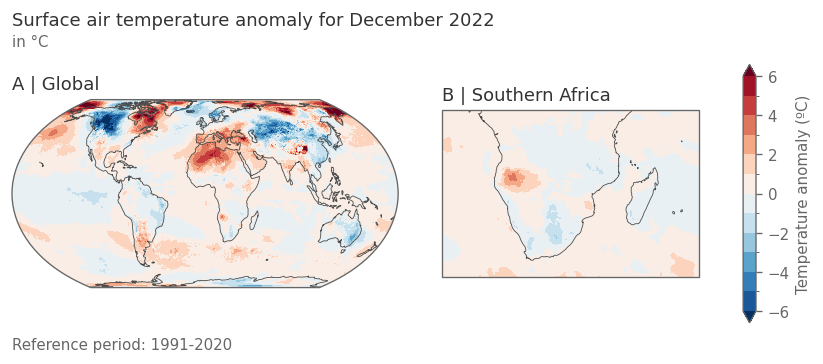

In [13]:
region = "Southern Africa"


# Recreate the figures similar to the C3S Monthly Bulletins
fig = plt.figure(figsize=(8, 3), dpi=120)
gs = GridSpec(
    3, 3, figure=fig, width_ratios=[1.5, 1, 0.05], height_ratios=[0.05, 1, 0.05]
)

# Add the axes
tax = fig.add_subplot(gs[0, 0])
bax = fig.add_subplot(gs[2, 0])
ax1 = fig.add_subplot(gs[1, 0], projection=PROJS["Global"])
ax2 = fig.add_subplot(gs[1, 1], projection=PROJS[region])
cax = fig.add_subplot(gs[1, 2])

# Set the extent of the maps
ax1.set_global()
ax2.set_extent(get_extent_from_region(region), crs=PROJS["Data"])

# Add coastlines and anomlies
for ax in [ax1, ax2]:
    ax.coastlines(lw=0.5, color=".3")
    era5_in_2022.plot(ax=ax, cbar_ax=cax, **kwargs)

# Add titles, labels and text
ax1.set_title("A | Global")
ax2.set_title("B | {}".format(region))

# Get month and add to title
month_number = era5_in_2022.time.dt.month.item()
title = f"Surface air temperature anomaly for {calendar.month_name[month_number]} 2022"
tax.set_title(title)
# Add units to subtitle
tax.text(0, 0, "in °C", ha="left", va="bottom", transform=tax.transAxes)
tax.axis("off")

# Get the reference period and add to the bottom left
bax.axis("off")
ref_start = REF_PERIOD["time"].start
ref_end = REF_PERIOD["time"].stop
bax.text(
    0,
    0,
    f"Reference period: {ref_start}-{ref_end}",
    ha="left",
    va="bottom",
    transform=bax.transAxes,
)

# Tweak the layout
fig.subplots_adjust(bottom=0.0, hspace=0.02)
plt.show()

Global View: You'll notice a rather heterogeneous pattern of positive and negative anomalies. In our target region, Southern Africa, positive anomalies appear in southwestern Africa, while the remaining areas show negative anomalies.

#### Analysing Anomalies in Context

How do these anomalies fit within global warming? We'll use spatial averages over our target region to show temporal trends. Here's how:

1. **Calculate Spatial Averages**: Use a helper function for this calculation, which we've previously used in Part I and II.

In [14]:
def weighted_spatial_average(da, region, land_mask=None):
    """Calculate the weighted spatial average of a DataArray.

    Parameters
    ----------
    da : xr.DataArray
        The DataArray to average.
    weights : xr.DataArray, optional
        A DataArray with the same dimensions as `da` containing the weights.
    """
    da = da.sel(**region)

    # Area weighting: calculate the area of each grid cell
    weights = np.cos(np.deg2rad(da.lat))

    # Additional user-specified weights, e.g. land-sea mask
    if land_mask is not None:
        land_mask = land_mask.sel(**region)
        weights = weights * land_mask.fillna(0)

    return da.weighted(weights).mean(("lat", "lon"))

2. **Include Other Regions as Reference**: To view the temperature anomalies in Southern Africa in both temporal and spatial contexts, calculate the spatial average not only for Southern Africa but also the global average and the Arctic, warming at [almost 4 times the global average](https://doi.org/10.1038/s43247-022-00498-).

3. **Focus on Satellite-era Data**: We'll only look at temperature anomalies of the satellite era (from 1979) due to greater uncertainty in the temperatures of previous years, [especially outside Europe](https://doi.org/10.21957/ly5vbtbfd).

In [15]:
# Running twelve-month averages of global-mean, South Africa-mean, and Arctic-mean
# surface air temperature anomalies relative to 1991-2020
# -----------------------------------------------------------------------------
era5_anoms = era5["anom"].sel(time=slice("1979", None))
era5_global_mean = weighted_spatial_average(
    era5_anoms, REGIONS["Global"], land_mask=None
)
era5_sa_mean = weighted_spatial_average(
    era5_anoms, REGIONS["Southern Africa"], era5["lsm"]
)
era5_arctic_mean = weighted_spatial_average(
    era5_anoms, REGIONS["Arctic"], era5["lsm"]
)

with ProgressBar():
    era5_global_mean = era5_global_mean.compute()
    era5_sa_mean = era5_sa_mean.compute()
    era5_arctic_mean = era5_arctic_mean.compute()


[########################################] | 100% Completed | 226.70 s
[########################################] | 100% Completed | 104.45 s
[########################################] | 100% Completed | 115.55 s


4. **Applying a 12-Month Running Average for Visualization**:

In [16]:
era5_global_mean_smooth = era5_global_mean.rolling(time=12, center=True).mean()
era5_sa_mean_smooth = era5_sa_mean.rolling(time=12, center=True).mean()
era5_arctic_mean_smooth = era5_arctic_mean.rolling(time=12, center=True).mean()

1. **Plotting Comparisons**: The following cell will plot a summary of the temperature anomaly development in the 3 target regions over the last ~40 years. Note the strong temperature rise during an extreme El-Niño in 2015/16, influencing various climate variables even in remote parts of the world like the Arctic or Southern Africa due to ENSO's [teleconnections](https://www.noaa.gov/jetstream/enso_impacts).

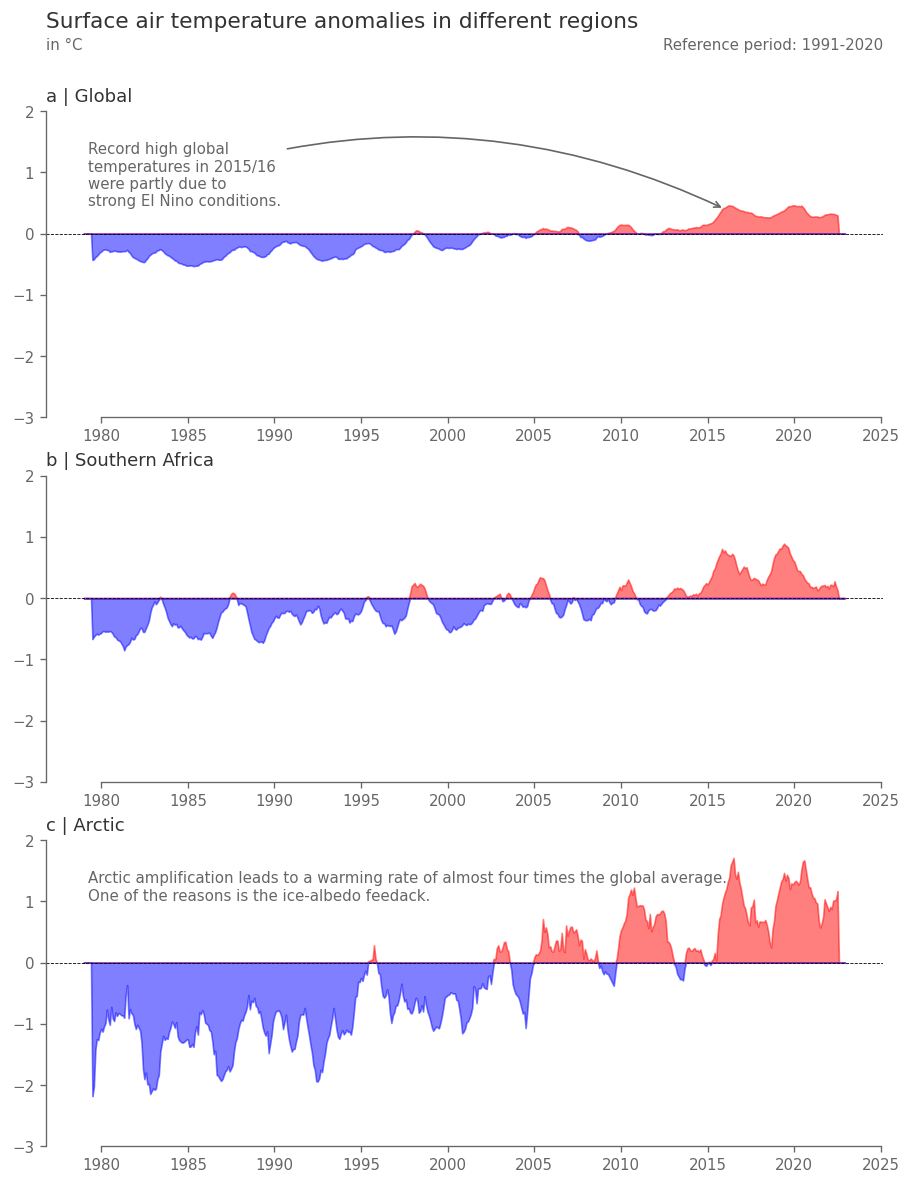

In [17]:
fig = plt.figure(figsize=(9, 12), dpi=120)
gs = GridSpec(4, 1, figure=fig, height_ratios=[0.05, 1, 1, 1], hspace=0.25)

tax = fig.add_subplot(gs[0, 0])
axes = [fig.add_subplot(gs[i, 0]) for i in range(1, 4)]


def add_time_series(da, ax):
    ax.fill_between(
        da.time,
        da.where(da > 0, 0).values,
        color="red",
        alpha=0.5,
    )
    ax.fill_between(
        da.time,
        da.where(da < 0, 0).values,
        color="blue",
        alpha=0.5,
    )


add_time_series(era5_global_mean_smooth, axes[0])
add_time_series(era5_sa_mean_smooth, axes[1])
add_time_series(era5_arctic_mean_smooth, axes[2])

# Add annotations describing the data
desc_global = "Record high global \ntemperatures in 2015/16 \nwere partly due to \nstrong El Nino conditions."
desc_artic = "Arctic amplification leads to a warming rate of almost four times the global average.\nOne of the reasons is the ice-albedo feedack."
axes[0].annotate(
    desc_global,
    xy=(dt.datetime(2016, 1, 1), 0.4),
    xytext=(0.05, 0.9),
    textcoords=axes[0].transAxes,
    ha="left",
    va="top",
    arrowprops=dict(arrowstyle="->", color=".4", connectionstyle="arc3,rad=-0.2"),
)
axes[2].text(0.05, 0.9, desc_artic, transform=axes[2].transAxes, ha="left", va="top")

titles = ["Global", "Southern Africa", "Arctic"]
for i, ax in enumerate(axes):
    ax.set_ylim(-3, 2)
    ax.axhline(0, color="k", ls="--", lw=0.5)
    ax.set_title(f"{ABC[i]} | {titles[i]}")
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
tax.axis("off")
tax.set_title("Surface air temperature anomalies in different regions", fontsize="x-large")
tax.text(0, 0, "in °C", ha="left", va="bottom", transform=tax.transAxes)
ref_start = REF_PERIOD["time"].start
ref_end = REF_PERIOD["time"].stop
tax.text(
    1,
    0,
    f"Reference period: {ref_start}-{ref_end}",
    ha="right",
    va="bottom",
    transform=tax.transAxes,
)

sns.despine(fig, trim=True)


#### Summary

Welcome to the end of the tutorial, which also marks the conclusion of our trilogy.
In this notebook, we've primarily focused on reconstructing images related to temperature anomalies from the monthly [Climate Bulletins](https://climate.copernicus.eu/climate-bulletins). We've built upon the concepts already learned in Parts I and II of Chapter 2.

In the next chapters, we'll continue to explore the direct consequences of temperature rise by reconstructing various illustrations on topics such as Sea Ice and Sea Level Rise from the C3S Climate Bulletins and ESTOC reports.